In [6]:
import csv
import pandas as pd
import numpy as np
import filters
import matplotlib.pyplot as pyp
import scipy.signal as signal
import numpy.fft as fft
import matplotlib
%matplotlib inline

In [7]:
pastel_colors = ['#FF6666','#FFCC66','#CCFF66','#66FF66','#66FFCC','#66FFFF','#66CCFF','#6666FF','#CC66FF','#FF66FF','#FF6FCF']
bright_colors = ['#FF0000','#FF8000','#FFFF00','#80FF00','#00FF00','#00FF80','#00FFFF','#0080FF','#0000FF','#8000FF','#FF00FF']
bright_colors2 = bright_colors = ['#FF0000','#FF8000','#80FF00','#00FF80','#0080FF','#0000FF','#8000FF','#FF00FF','#FF0080']
pyp.rcParams['font.size']=18
pyp.rcParams['legend.labelspacing'] = 0.1

In [1]:
#constants
kB_W_Hz_K = 1.38064852e-23 # Watts / Hz / K
speed_of_light = 2.988e8
Z_0 = 377.
Z_L = 50.
R_L = 50.

In [9]:
def temp(f_MHz):
    # Dulk 2001
    nu = f_MHz # Hz
    tau = 5.0 * pow(nu, -2.1)
    Ieg = 1.0610e-20
    Ig  = 2.48e-20
    # Iv in  W/m^2/Hz/sr
    Iv = Ig * pow(nu, -0.52) * (1-np.exp(-tau))/tau + Ieg * pow(nu, -0.80) * np.exp(-tau)
    
    kB = 1.38064852e-23 # Watts / Hz / K
    c = 299792458 # m/s
    temp = Iv * c**2 / (2*(nu*1e6)**2)/kB

    return Iv, temp # W/m^2/Hz/sr, K

def read_npz_files(antenna_height, zenith):
    npzfile = np.load("/Users/wissels/Dropbox/MountainTop/harms_sims/npz_files/altitude_%dkm_zenith_%d.npz"%(antenna_height, zenith))
    efield_td = npzfile['efield_td'][()] ## for some reason just reading the arrays gives a 0-dim array, so skip this.
    efield_fd = npzfile['efield_fd'][()]
    return efield_td, efield_fd

['y_v_per_m', 'z_v_per_m', 'x_v_per_m', 'time_s']
['freq_hz', 'x_v_per_m_Hz', 'z_v_per_m_Hz', 'y_v_per_m_Hz']


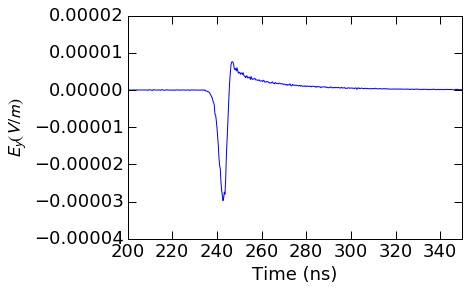

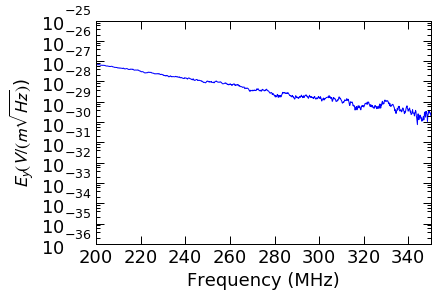

In [10]:
h = 3
z = 87
offangle = 1
efield_td, efield_fd = read_npz_files(h,z)
print efield_td[offangle].keys()
print efield_fd[offangle].keys()

def simulated_signal_td(offangle):
    '''Returns the selected simulation sampled at 
    the input off-angle (divided by 10). Simulations range between 0.1 and 4.1 degrees.
    For example, to get the waveform on the cone, use offangle=12'''
    efield = efield_td[offangle]['y_v_per_m']
    time = efield_td[offangle]['time_s']
    return np.array(time), np.array(efield)

def simulated_signal_fd(offangle):
    efield = efield_fd[offangle]['y_v_per_m_Hz']
    freq = efield_fd[offangle]['freq_hz']
    return np.array(freq), np.array(efield)

pyp.figure(1)
time, efield = simulated_signal_td(offangle)
pyp.plot((time-min(time))*1e9, efield)
pyp.xlim(200,350)
pyp.xlabel("Time (ns)")
pyp.ylabel("$E_y (V/m)$")

pyp.figure(2)
freq, efield = simulated_signal_fd(offangle)
pyp.semilogy((freq)/1e6, efield)
pyp.xlim(200,350)
pyp.xlabel("Frequency (MHz)")
pyp.ylabel("$E_y (V/(m \sqrt{Hz})$)")

In [11]:
def noise_power(fstart, fstop):
    if(fstop == 0.):
        fstop = max(efield_fd[1]['freq_hz'])
    df = efield_fd[1]['freq_hz'][1] - efield_fd[1]['freq_hz'][0]
    freq = np.arange(fstart, fstop, df) # in Hertz
    
    # get the galactic noise power in the band
    noise_temp = temp(freq/1e6)[1]
    kB_W_Hz_K = 1.38064852e-23 # Watts / Hz / K
    
    # sum the power with a coherent power sum for the signal and incoherent for the noise
    incoherent_noise_sum = np.sum(noise_temp*kB_W_Hz_K*df)
    return incoherent_noise_sum

In [12]:
noise_low = noise_power(30e6, 80e6)
noise_high = noise_power(300e6, 1200e6)

In [13]:
print noise_low, kB_W_Hz_K * 50e6 * 10000, np.sqrt(noise_low*Z_L)*1e6
print noise_high, kB_W_Hz_K * 900e6 * 100, np.sqrt(noise_high*Z_L)*1e6

3.72610456555e-12 6.9032426e-12 13.6493673215
1.19091096532e-13 1.242583668e-12 2.44019565335


In [14]:
def bandpassed_signal(offangle, fstart, fstop):
    _efield = efield_td[offangle]['y_v_per_m']
    _time = efield_td[offangle]['time_s']
    dt = _time[1]-_time[0]
    _efield_filt = filters.butter_bandpass_filter(_efield,fstart,fstop,1./dt)
    return _time, _efield_filt

def bandpassed_coherent_sum_signal(fstart,fstop):
    for offangle in range(1,41,1):
        time, off_angle_efield_filt = bandpassed_signal(offangle, fstart, fstop)
        if(offangle == 1):
            efield_filt = off_angle_efield_filt
        else:
            efield_filt += off_angle_efield_filt
    return time, efield_filt

def coherent_power_sum_voltage_td(voltage,dt):
    return np.sum(voltage**2 )/Z_L *dt  

def coherent_power_sum_voltage_fd(voltage, dt):
    return np.sum(np.abs(voltage)**2)/Z_L  * dt / len(voltage)

def voltage(offangle, fstart, fstop, gain):
    time, off_angle_efield_filt = bandpassed_signal(offangle, fstart, fstop)
    efield_fft = fft.rfft(off_angle_efield_filt)
    N = len(off_angle_efield_filt)
    freq = fft.rfftfreq(N, time[1]-time[0])
    voltage_fft = efield_fft * np.sqrt(4.*Z_L/Z_0 * pow(speed_of_light/freq,2)/(4.*np.pi) * gain)
    voltage_fft[0] = 0
    volt = fft.irfft(voltage_fft)
    return time, volt, freq, voltage_fft

def bandpassed_power_per_angle(fstart, fstop, gain=1, td=True):
    coherent_signal_sum = 0.
    power_offangles = []
    
    for offangle in range(1,41,1):
        time, volt, freq, voltage_fft = voltage(offangle, fstart, fstop, gain)
        #power_offangles.append(coherent_power_sum_voltage_td(volt, time[1]-time[0]))
        N = len(volt)
        dt = time[1] - time[0]
        #fft_norm = np.sqrt(2)/np.sqrt(N) # sqrt(2) accounts for real part of specturm 
        if( td):
            power_offangles.append(coherent_power_sum_voltage_td(volt, dt )/dt)
        else:
            power_offangles.append(coherent_power_sum_voltage_fd(voltage_fft, dt)/dt)
        
    power_off_angles = np.array(power_offangles)
    
    coherent_signal_sum = np.sum(power_off_angles)
    return np.arange(0.1, 4.1,0.1), power_off_angles, coherent_signal_sum

In [15]:
offangles, powers_low, total_power_low = bandpassed_power_per_angle(30e6, 80e6)
offangles, powers_high, total_power_high = bandpassed_power_per_angle(300e6, 1200e6)
offangles, powers_low, total_power_low_fd = bandpassed_power_per_angle(30e6, 80e6,td=False)
offangles, powers_high, total_power_high_fd = bandpassed_power_per_angle(300e6, 1200e6,td=False)

/Users/wissels/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:28: RuntimeWarning: divide by zero encountered in divide
/Users/wissels/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:28: RuntimeWarning: invalid value encountered in multiply


In [16]:
print freq[1]-freq[0], 1./(freq[1]-freq[0]), len(freq)
print time[1]-time[0], 1./(time[1]-time[0]), len(time)
print (time[1]-time[0])*(freq[1]-freq[0])

166675.00042 5.99969999988e-06 9999
2.99999999967e-10 3333333333.7 19999
5.00025001205e-05


In [17]:
print total_power_low, np.sqrt(total_power_low * Z_L)*1e6, np.sqrt(2)*np.sqrt(total_power_low_fd * Z_L)*1e6
print total_power_high, np.sqrt(total_power_high * Z_L)*1e6, np.sqrt(2)*np.sqrt(total_power_high_fd * Z_L)*1e6

print "Power matches rough estimates by Andres and Steph of\n\tEpeak ~8-20 uV over ~20 ns pulse at 30-80 MHz."

8.93635585604e-09 668.444307929 945.275738632
1.50886211835e-10 86.8579909492 122.82960686
Power matches rough estimates by Andres and Steph of
	Epeak ~8-20 uV over ~20 ns pulse at 30-80 MHz.


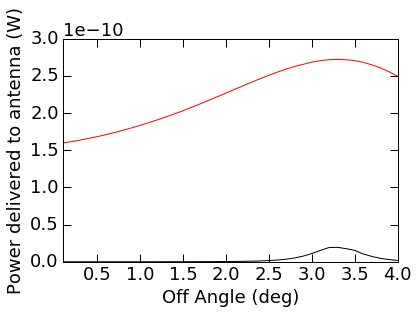

In [18]:
pyp.plot(offangles,powers_low, 'r')
pyp.plot(offangles,powers_high, 'k')
pyp.xlim(0.1,4)
pyp.ylim(0)
pyp.xlabel("Off Angle (deg)")
pyp.ylabel("Power delivered to antenna (W)")

In [19]:
fstart=30e6
fstop=80e6
gain=1
peak_voltages = np.zeros(40)
for offangle in range(1,41,1):
        time, off_angle_efield_filt = bandpassed_signal(offangle, fstart, fstop)
        efield_fft = fft.rfft(off_angle_efield_filt)
        freq = fft.rfftfreq(len(off_angle_efield_filt), time[1]-time[0])
        #voltage_fft = efield_fft
        voltage_fft = efield_fft * np.sqrt(4.*Z_L/Z_0 * pow(speed_of_light/freq,2)/(4.*np.pi) * gain)
        voltage_fft[0] = 0
        volt = fft.irfft(voltage_fft)
        peak_voltages[offangle-1]=max(abs(volt))


/Users/wissels/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: RuntimeWarning: divide by zero encountered in divide
/Users/wissels/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: RuntimeWarning: invalid value encountered in multiply


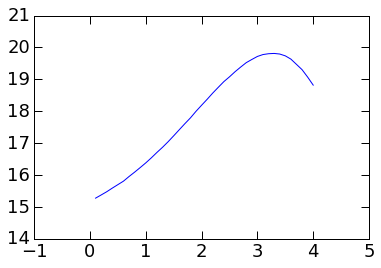

In [20]:
pyp.plot(np.arange(0.1,4.1, 0.1), peak_voltages/1e-6)

In [21]:
fstart=30e6
fstop=80e6
gain=1
peak_voltages = np.zeros(40)
for offangle in range(1,41,1):
        time, off_angle_efield_filt = bandpassed_signal(offangle, fstart, fstop)
        efield_fft = fft.rfft(off_angle_efield_filt)
        freq = fft.rfftfreq(len(off_angle_efield_filt), time[1]-time[0])
        #voltage_fft = efield_fft
        voltage_fft = efield_fft * np.sqrt(4.*Z_L/Z_0 * pow(speed_of_light/freq,2)/(4.*np.pi) * gain)
        voltage_fft[0] = 0
        volt = fft.irfft(voltage_fft)
        peak_voltages[offangle-1]=max(abs(volt))

/Users/wissels/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: RuntimeWarning: divide by zero encountered in divide
/Users/wissels/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: RuntimeWarning: invalid value encountered in multiply


In [22]:
fstart=300e6
fstop=1200e6
gain=1
peak_voltages = np.zeros(40)
for offangle in range(1,41,1):
        time, off_angle_efield_filt = bandpassed_signal(offangle, fstart, fstop)
        efield_fft = fft.rfft(off_angle_efield_filt)
        freq = fft.rfftfreq(len(off_angle_efield_filt), time[1]-time[0])
        #voltage_fft = efield_fft
        voltage_fft = efield_fft * np.sqrt(4.*Z_L/Z_0 * pow(speed_of_light/freq,2)/(4.*np.pi) * gain)
        voltage_fft[0] = 0
        volt = fft.irfft(voltage_fft)
        peak_voltages[offangle-1]=max(abs(volt))



/Users/wissels/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: RuntimeWarning: divide by zero encountered in divide
/Users/wissels/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: RuntimeWarning: invalid value encountered in multiply


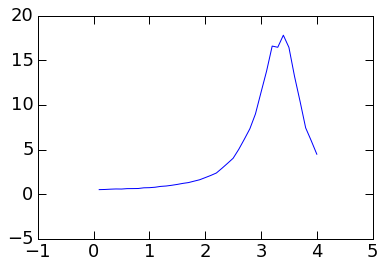

In [23]:
pyp.plot(np.arange(0.1,4.1, 0.1), peak_voltages/1e-6)

In [24]:
def beam_power_ratio(fstart=0., fstop=0):
    # select a single polarization. Vertical in this case
    # filter it.
    
    # add up the received signals at all the antennas
    #time, efield_filt = bandpassed_coherent_sum_signal(fstart, fstop)
    coherent_signal_sum = bandpassed_power_per_angle(fstart, fstop)[2]

    incoherent_noise_sum = noise_power(fstart, fstop) * 41 
    pratio = coherent_signal_sum / incoherent_noise_sum
    return pratio, coherent_signal_sum, incoherent_noise_sum

In [25]:
### two-dimensional scan of bandwidth and center frequency
start_frequencies = np.arange(30e6, 300e6, 5e6)
bandwidths = np.arange(30e6, 300e6, 5e6)

pratios2 = []
noise_powers2 = []
signal_powers2 = []
noise_temps2 = []

for bw in bandwidths:
    pratios = []
    noise_powers = []
    signal_powers = []
    noise_temps = []
    for sf in start_frequencies:
        #print cf, bw, fstart, fstop
        fstart = sf
        fstop  = sf + bw
        #print cf/1e6, bw/1e6, fstart/1e6, fstop/1e6
        
        pratio, signal_power, noise = beam_power_ratio(fstart=fstart, fstop=fstop)
        pratios.append(pratio)
        noise_powers.append(noise)
        signal_powers.append(signal_power)
    pratios2.append(pratios)
    noise_powers2.append(noise_powers)
    signal_powers2.append(signal_powers)

/Users/wissels/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:28: RuntimeWarning: divide by zero encountered in divide
/Users/wissels/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:28: RuntimeWarning: invalid value encountered in multiply


In [ ]:
#setup the 2D grid with Numpy
start_freq, bands = np.meshgrid(start_frequencies, bandwidths)

#convert intensity (list of lists) to a numpy array for plotting

pratios2 = np.array(pratios2)

#now just plug the data into pcolormesh, it's that easy!
pyp.figure(1)
mcolors = matplotlib.colors.Normalize(vmin=pratios2.min()/pratios2.max(),
                                      vmax=1.,)
pyp.pcolormesh(start_freq/1e6, bands/1e6, pratios2/pratios2.max(), 
               norm=mcolors, cmap='plasma')
pyp.colorbar() #need a colorbar to show the intensity scale

pyp.xlim(30,300)
pyp.ylim(30,300)
CS = pyp.contour(start_freq/1e6, bands/1e6, pratios2/pratios2.max(), 8, colors='k')
manual_locations = [(75,150),(75,200),(100,200), (150,200),(175,200), (200,200),(250,200) ]
pyp.clabel(CS, inline=1, fontsize=12, manual=manual_locations)

pyp.xlabel("Starting Frequency (MHz)")
pyp.ylabel("Bandwidth (MHz)")
pyp.title("Normalized Ratio of Coherent Power to Noise Power ", y=1.1)
pyp.savefig("/Users/wissels/Dropbox/MountainTop/AntennaStudy/pulse_power_over_noise_power_contour_norm_%dkm_%ddeg.png"%(h,z))

pyp.figure(2)
#now just plug the data into pcolormesh, it's that easy!

pyp.pcolormesh(start_freq/1e6, bands/1e6, pratios2, 
               cmap='plasma')
pyp.colorbar() #need a colorbar to show the intensity scale

pyp.xlim(30,300)
pyp.ylim(30,300)
CS = pyp.contour(start_freq/1e6, bands/1e6, pratios2/pratios2.max(), 8, colors='k')
manual_locations = [(75,150),(75,200),(100,200), (150,200),(175,200), (200,200),(250,200) ]
pyp.clabel(CS, inline=1, fontsize=12, manual=manual_locations)

pyp.xlabel("Starting Frequency (MHz)")
pyp.ylabel("Bandwidth (MHz)")
pyp.title("Normalized Ratio of Coherent Power to Noise Power ", y=1.1)
pyp.savefig("/Users/wissels/Dropbox/MountainTop/AntennaStudy/pulse_power_over_noise_power_contour_%dkm_%ddeg.png"%(h,z))